# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [33]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [34]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_features <class 'numpy.ndarray'> (40504, 512) float32
word_to_idx <class 'dict'> 1004
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
idx_to_word <class 'list'> 1004


In [111]:
num_val = data["val_features"].shape[0]

In [112]:
num_val

40504

In [35]:
import tensorflow as tf
from tensorflow.contrib import seq2seq
from tensorflow.python.layers import core as layers_core
import nltk

In [216]:
START = data["word_to_idx"]["<START>"]
END = data["word_to_idx"]["<END>"]

input_dim = data['train_features'].shape[1]
n_words = len(data['word_to_idx'])
num_hidden = 1536
wordvec_dim = 256

In [217]:
tf.reset_default_graph()

image_repr = tf.placeholder(tf.float32, shape=[None, input_dim], name="image_representation")
target_sequence = tf.placeholder(tf.int64, shape=[None, None], name="target_sequence")
lr = tf.placeholder_with_default(1e-3, [])

In [218]:
mask_sequence_int = tf.cast(target_sequence > 0, tf.int32)
mask_sequence = tf.cast(mask_sequence_int, tf.float32)
target_len = tf.reduce_sum(mask_sequence_int, axis=1)
current_batch_size, _ = tf.unstack(tf.shape(image_repr))

In [219]:
max_target_len = tf.reduce_max(target_len)

In [220]:
target_used = target_sequence[:, : max_target_len]
mask_sequence_used = mask_sequence[:, :max_target_len]

In [221]:
words_embedding = tf.Variable(tf.random_normal(shape=[n_words, wordvec_dim]) / 100)
target_embed = tf.nn.embedding_lookup(words_embedding, target_used)

h0 = tf.layers.dense(image_repr, num_hidden)
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_hidden)
lstm_init_state = tf.nn.rnn_cell.LSTMStateTuple(tf.zeros_like(h0), h0)

In [222]:
test_helper = seq2seq.GreedyEmbeddingHelper(embedding=words_embedding, 
                                           start_tokens=tf.fill([current_batch_size], START), end_token=END)
train_helper = seq2seq.TrainingHelper(inputs=target_embed, sequence_length=target_len - 1, time_major=False)

In [223]:
out_proj = layers_core.Dense(n_words, use_bias=False)
train_decoder = seq2seq.BasicDecoder(lstm_cell, train_helper, lstm_init_state, out_proj)
test_decoder = seq2seq.BasicDecoder(lstm_cell, test_helper, lstm_init_state, out_proj)

with tf.variable_scope("decoder", reuse=False):
    decoder_outputs_train, _, decoder_outputs_train_len =  seq2seq.dynamic_decode(train_decoder, output_time_major=False)
with tf.variable_scope("decoder", reuse=True):
    decoder_outputs_test, _, decoder_outputs_test_len =  seq2seq.dynamic_decode(test_decoder, output_time_major=False, maximum_iterations=16)

In [224]:
logits = decoder_outputs_train.rnn_output
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target_used[:, 1:], logits=logits)
loss = tf.reduce_sum(crossent * mask_sequence_used[:, 1:]) / tf.cast(current_batch_size, tf.float32)

In [225]:
predictions = tf.argmax(decoder_outputs_test.rnn_output, axis=-1)
cheat_predictions = tf.argmax(decoder_outputs_train.rnn_output, axis=-1)

In [226]:
optimizer = tf.train.AdamOptimizer(1e-3)
train_op = optimizer.minimize(loss)

In [227]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [228]:
def get_captions(features):
    feed_dict = {image_repr: features,}
    captions = sess.run(predictions, feed_dict=feed_dict)
    return captions

In [229]:
def get_captions_cheat(features, sequences):
    feed_dict = {image_repr: features, target_sequence: sequences}
    captions = sess.run(cheat_predictions, feed_dict=feed_dict)
    return captions

In [230]:
def run_epoch(learning_rate=1e-3):
    n_examples = data['train_image_idxs'].shape[0]
    for step in range(n_examples // batch_size):
        idx = np.random.choice(n_examples, size=[batch_size, ], replace=False)
        feed_dict = {image_repr: data["train_features"][data['train_image_idxs'][idx]],
                     target_sequence: data["train_captions"][idx],
                     lr: learning_rate}
        l, _  = sess.run([loss, train_op], feed_dict=feed_dict)
        if step % 100 == 0:
            print(l)

In [231]:
def visually_test_model():
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
        gt_captions_int, features, urls = minibatch
        gt_captions = decode_captions(gt_captions_int, data['idx_to_word'])

        sample_captions = get_captions(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        cheat_captions_int = get_captions_cheat(features, gt_captions_int)
        cheat_captions = decode_captions(cheat_captions_int, data['idx_to_word'])


        for gt_caption, sample_caption, cheat_caption, url in zip(gt_captions, sample_captions, cheat_captions, urls):
            plt.imshow(image_from_url(url))
            print(split)
            print("Caption: {}".format(sample_caption))
            print("Cheat caption: {}".format(cheat_caption))
            print("True caption: {}".format(gt_caption))
            plt.axis('off')
            plt.show()

In [232]:
def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model_BLUE():
    BLEUscores = dict()
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=num_val) # full val!
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = get_captions(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))
    return BLEUscores

In [233]:
done_epochs = 0
batch_size = 512

Epoch 1
77.736
35.2042
30.1885
28.0004
27.3188
26.5188
24.7933
24.0208
train
Caption: a stop sign with a <UNK> <UNK> on it <END>
Cheat caption: a stop sign with <UNK> with a signs <END>
True caption: <START> a stop sign is topped by street signs on a residential street <END>


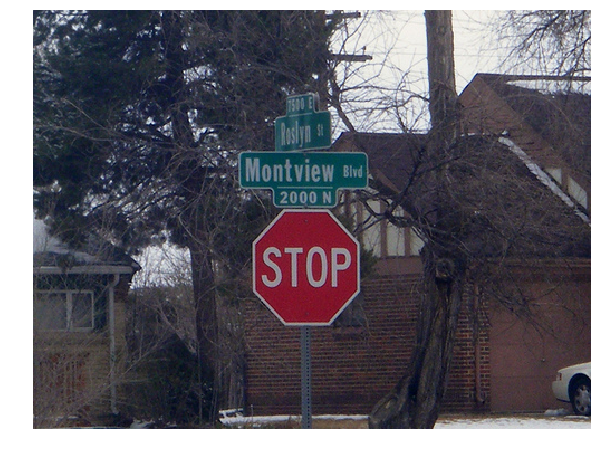

train
Caption: a plane flying in the air with a sky background <END>
Cheat caption: a airplane flying off from the in sunset <END>
True caption: <START> an airplane taking off over trees at sunset <END>


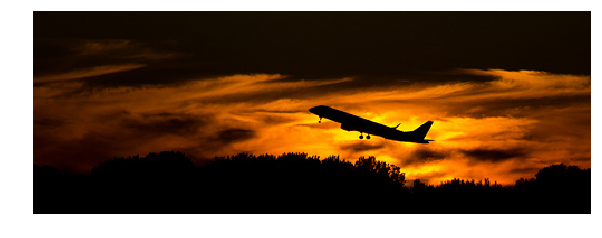

val
Caption: a <UNK> <UNK> <UNK> in a kitchen with a <UNK> <END>
Cheat caption: a <UNK> room with a <UNK> with <UNK> <UNK> other <END>
True caption: <START> a living room and a kitchen new to each other <END>


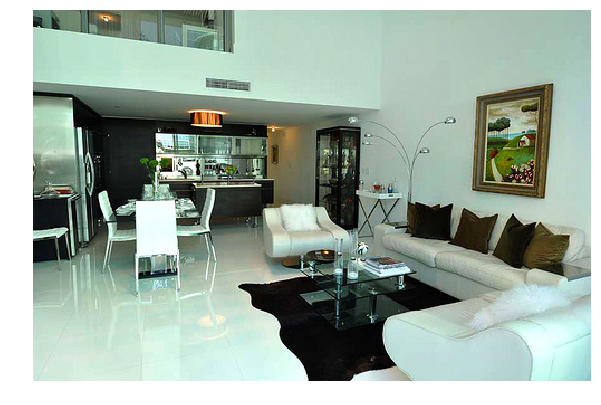

val
Caption: a bathroom with a toilet and a sink <END>
Cheat caption: a bathroom <UNK> in a <UNK> in a bathroom <END>
True caption: <START> a towel <UNK> beneath a sink in a bathroom <END>


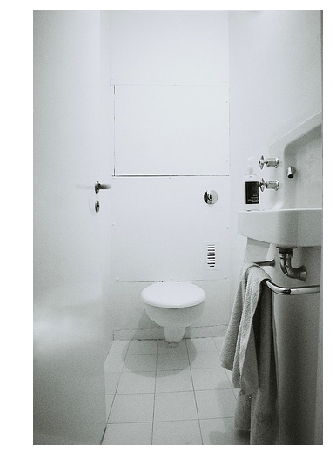

Average BLEU score for train: 0.302717
Average BLEU score for val: 0.285329

Epoch 2
25.4515
23.5742
24.3303
23.9227
23.4972
23.9367
23.5367
21.9147
train
Caption: a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <END>
Cheat caption: a <UNK> <UNK> <UNK> a <UNK> <UNK> of food <END>
True caption: <START> a <UNK> <UNK> behind a <UNK> plate of food <END>


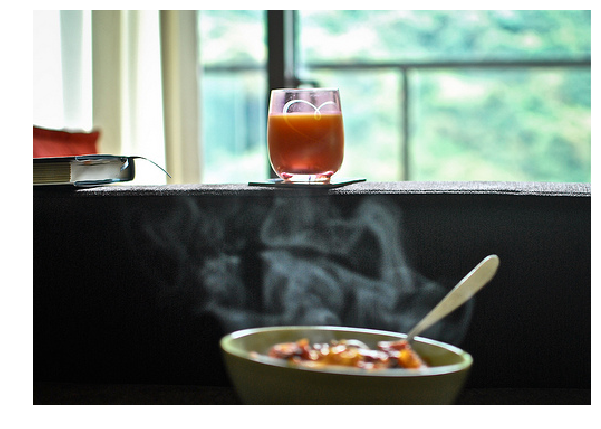

train
Caption: a bunch of <UNK> <UNK> on a table <END>
Cheat caption: a bananas are on on on a table <END>
True caption: <START> some doughnuts are sitting together on a tray <END>


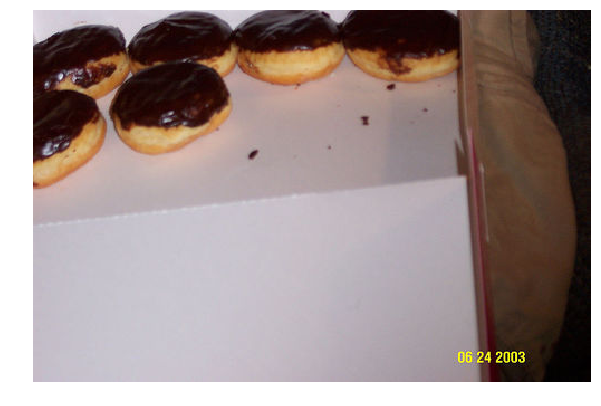

val
Caption: a kitchen with a refrigerator and a refrigerator <END>
Cheat caption: a kitchen of kitchen in sitting in in in the couch floor <END>
True caption: <START> a couple of guys are <UNK> up work on a kitchen <UNK> <END>


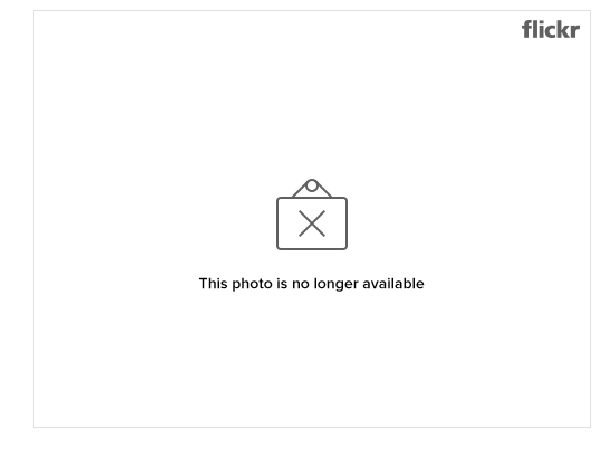

val
Caption: a group of zebras standing in a grassy area <END>
Cheat caption: a group zebras are on each in the camera <END>
True caption: <START> a few zebras graze with <UNK> towards the camera <END>


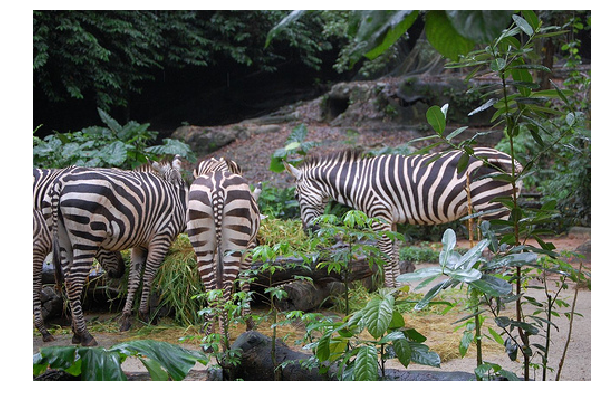

Average BLEU score for train: 0.321937
Average BLEU score for val: 0.293723

Epoch 3
22.0425
22.6875
21.8817
22.1448
21.2736
21.7202
21.4982
22.3191
train
Caption: a double decker bus driving down a street <END>
Cheat caption: a and black train traveling down a tracks <END>
True caption: <START> orange and yellow train traveling down its tracks <END>


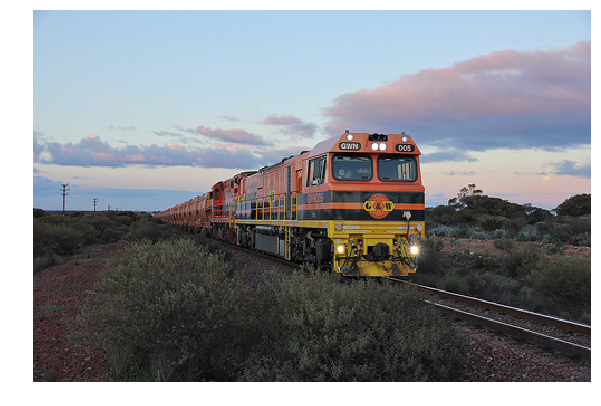

train
Caption: a man sitting on a bench on the beach <END>
Cheat caption: a man sitting a surfboard on he walks through the beach <END>
True caption: <START> a man holds a surfboard as he walks up the stairs <END>


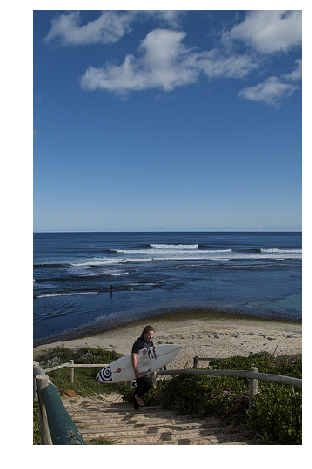

val
Caption: a man is playing tennis on a tennis court <END>
Cheat caption: a man and with at front middle station <END>
True caption: <START> a red train docked in the train station <END>


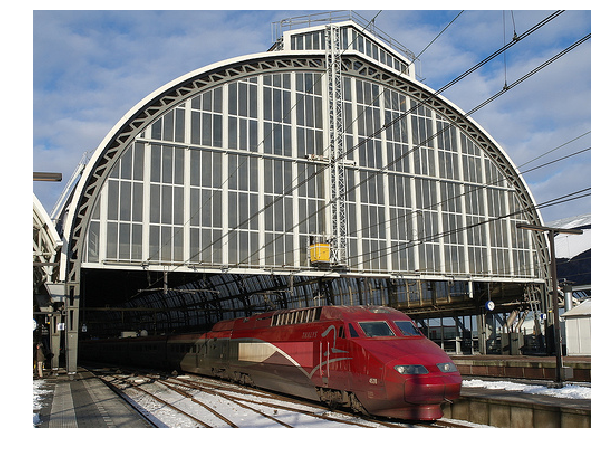

val
Caption: a little girl sitting in a chair with a <UNK> <END>
Cheat caption: a little with <UNK> on on a table table <END>
True caption: <START> a vase of flowers sitting on a glass table <END>


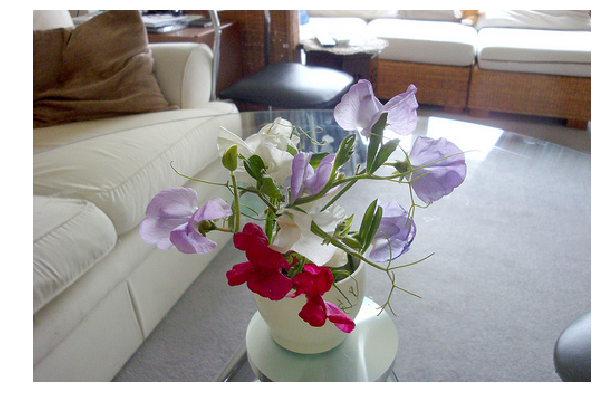

Average BLEU score for train: 0.334295
Average BLEU score for val: 0.297169

Epoch 4
21.3738
21.5151
21.4392
21.3797
21.6483
21.2425
20.8242
21.4711
train
Caption: a tennis player <UNK> a tennis ball on a tennis court <END>
Cheat caption: a tennis is a tennis racquet on him head <END>
True caption: <START> a man holding a tennis racket behind his head <END>


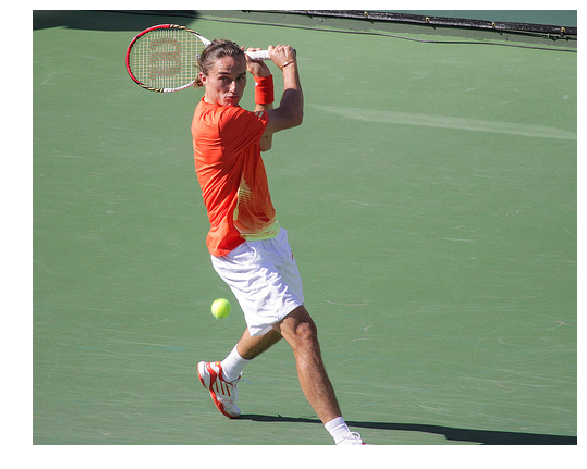

train
Caption: a bedroom with a bed and a <UNK> <END>
Cheat caption: a bedroom with be seen in the hotel <END>
True caption: <START> a bed can be seen across a room <END>


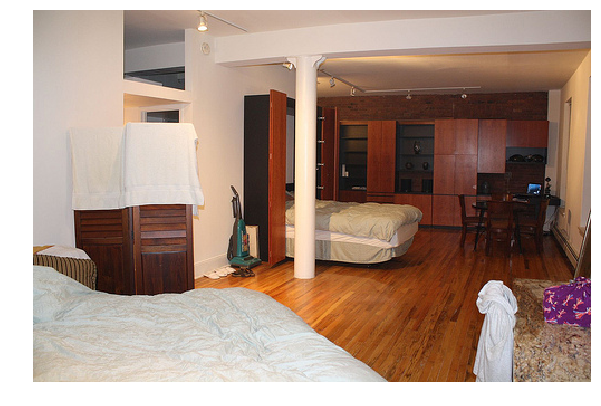

val
Caption: a bedroom with a bed and a desk <END>
Cheat caption: a bedroom view of a living living clean bedroom <END>
True caption: <START> a full view of a nice and <UNK> bed with pillows <END>


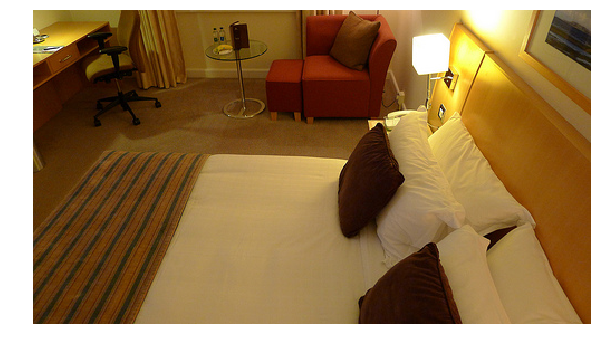

val
Caption: a train is stopped at a station with <UNK> <END>
Cheat caption: a train train is a next to a platform <END>
True caption: <START> a red train on tracks next to a building <END>


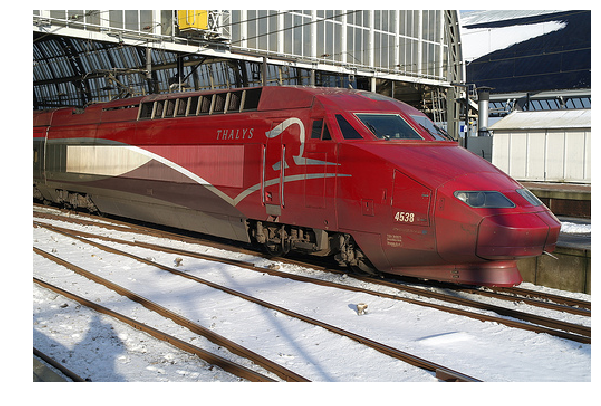

Average BLEU score for train: 0.344038
Average BLEU score for val: 0.300362
Achieved BLEU > 0.3
CPU times: user 9min 31s, sys: 1min 35s, total: 11min 6s
Wall time: 7min 41s


In [234]:
%%time
try:
    while True:
        print("Epoch {}".format(done_epochs + 1))
        run_epoch(1e-3)
        done_epochs += 1
        visually_test_model()
        scores = evaluate_model_BLUE()
        if scores['val'] > 0.3 and scores['train'] > 0.3:
            print("Achieved BLEU > 0.3")
            break
        print()
except KeyboardInterrupt:
    print("Training interrupted")

In [235]:
evaluate_model_BLUE()

Average BLEU score for train: 0.344218
Average BLEU score for val: 0.301439


{'train': 0.3442182024772195, 'val': 0.3014392581492559}

## Achieved BLEU > 0.3 after 4 epochs. LSTM 1536 hidden, PCA features

Epoch 5
21.0757
21.0414
20.8699
20.241
19.372
20.1548
20.1635
20.5835
train
Caption: a white plate topped with a sandwich and a cup of coffee <END>
Cheat caption: a <UNK> a <UNK> <UNK> with on a table <END>
True caption: <START> <UNK> for a chocolate dessert sitting on a counter <END>


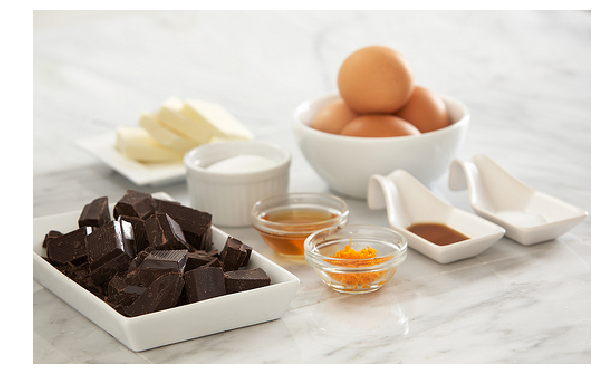

train
Caption: a bathroom with a toilet and a sink <END>
Cheat caption: a bathroom toilet sitting in a bathroom next to a paper <END>
True caption: <START> a white toilet sitting in a stall next to toilet paper <END>


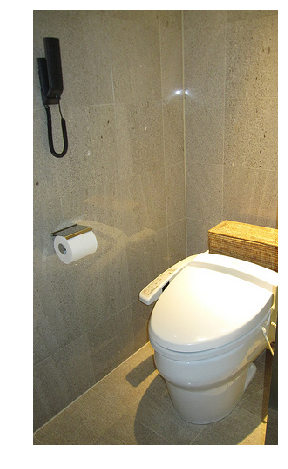

val
Caption: a woman <UNK> a <UNK> <UNK> a <UNK> <END>
Cheat caption: a people standing near a fence looking looking giraffe <END>
True caption: <START> three people standing near a fence and a horse <END>


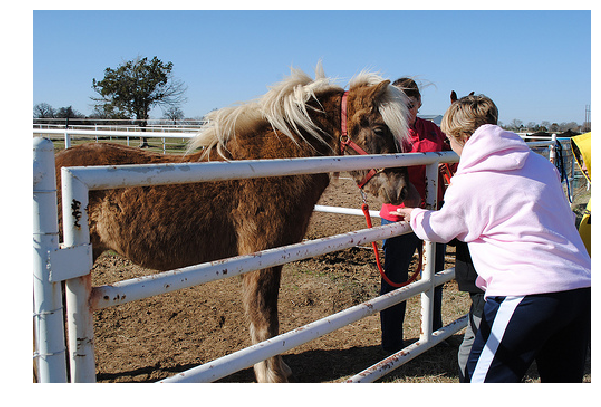

val
Caption: a group of giraffes standing in a field <END>
Cheat caption: a giraffes giraffes standing in the <UNK> area <END>
True caption: <START> two big giraffes walking in a grassy area with a baby giraffe <END>


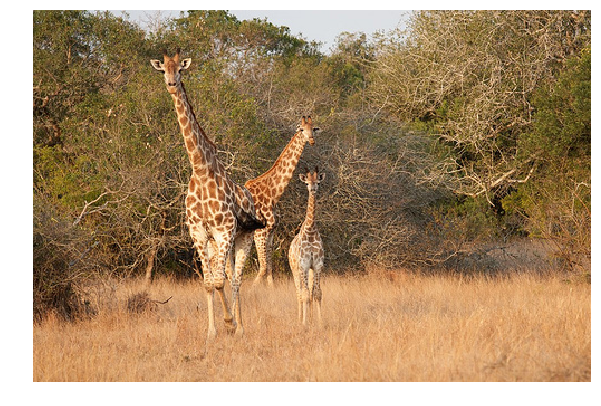

Average BLEU score for train: 0.351063
Average BLEU score for val: 0.303426
Achieved BLEU > 0.3
CPU times: user 2min 22s, sys: 22.9 s, total: 2min 45s
Wall time: 1min 54s


In [236]:
%%time
try:
    while True:
        print("Epoch {}".format(done_epochs + 1))
        run_epoch(1e-3)
        done_epochs += 1
        visually_test_model()
        scores = evaluate_model_BLUE()
        if scores['val'] > 0.3 and scores['train'] > 0.3:
            print("Achieved BLEU > 0.3")
            break
        print()
except KeyboardInterrupt:
    print("Training interrupted")